Loading ViT-B-32...
Successfully loaded custom weights.
Prediction: mammoet (80.30%)
Generating LIME (this may take a minute)...


  0%|          | 0/500 [00:00<?, ?it/s]

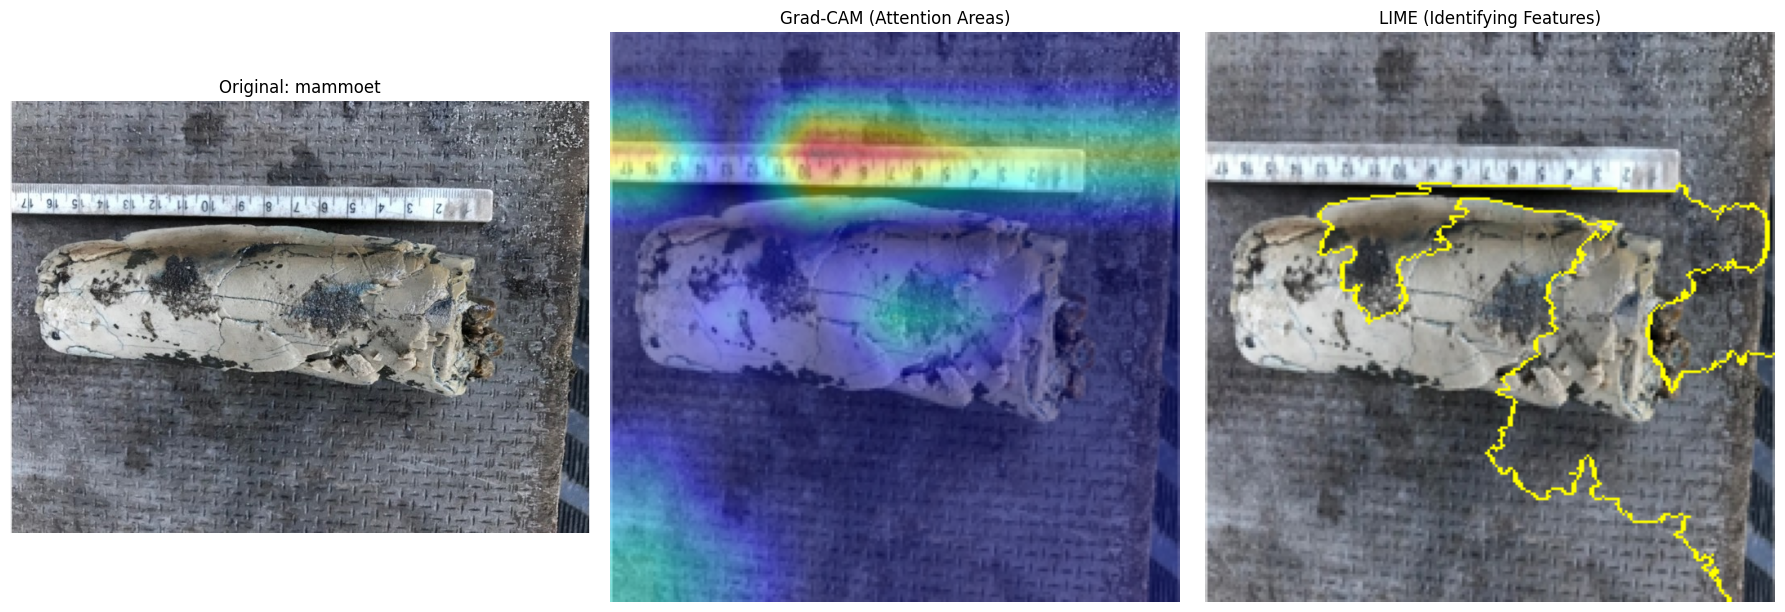

In [9]:
import torch
import torch.nn.functional as F
import open_clip
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries

# ==========================================
# 1. Configuration & Model Loading
# ==========================================
MODEL_NAME = 'ViT-B-32'
PRETRAINED = 'laion2b_s34b_b79k'
# Path to your custom weights (.pt or .pth file)
CUSTOM_WEIGHTS_PATH = "model/finetuned_clip.pt" 

device = "cuda" if torch.cuda.is_available() else "cpu"

# Vocabulary for identification
class_names = ["hond", "runderachtige", "rendier", "paard", "mammoet", "neushhorn", "oesterschelp", "schelp"]
labels_tokens = open_clip.tokenize(class_names).to(device)

def load_model():
    print(f"Loading {MODEL_NAME}...")
    model, _, preprocess = open_clip.create_model_and_transforms(MODEL_NAME, pretrained=PRETRAINED)
    
    try:
        checkpoint = torch.load(CUSTOM_WEIGHTS_PATH, map_location=device)
        # Handle different saving formats
        state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint
        model.load_state_dict(state_dict)
        print("Successfully loaded custom weights.")
    except:
        print("Using default LAION weights (Custom weights not found).")
    
    model.to(device).eval()
    return model, preprocess

model, preprocess = load_model()

# ==========================================
# 2. Manual Grad-CAM for ViT (No Library Needed)
# ==========================================
class ViTGradCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activations = None
        
        # Hook into the last layer normalization of the vision transformer
        target_layer = self.model.visual.transformer.resblocks[-1].ln_1
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_full_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, input_tensor, class_idx):
        # Forward pass
        img_features = self.model.encode_image(input_tensor)
        text_features = self.model.encode_text(labels_tokens)
        
        # Normalize
        img_features = img_features / img_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        # Compute Similarity (Logits)
        logits = 100.0 * img_features @ text_features.t()
        
        # Backward pass
        self.model.zero_grad()
        loss = logits[0, class_idx]
        loss.backward()

        # Grad-CAM Calculation
        # Activations/Gradients shape: [1, 257, 1280] (for ViT-H-14)
        grads = self.gradients.detach()
        weights = torch.mean(grads, dim=1, keepdim=True)
        cam = (weights * self.activations.detach()).sum(dim=-1).squeeze()
        cam = F.relu(cam)
        
        # Remove class token (index 0) and reshape to 16x16 grid
        cam = cam[1:].reshape(7, 7) 
        
        # Normalize heatmap
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam.cpu().numpy()

# Initialize Grad-CAM helper
vit_cam = ViTGradCAM(model)

# ==========================================
# 3. LIME Prediction Function
# ==========================================
def lime_predict(images):
    # Prepare batch for CLIP
    batch = torch.stack([preprocess(Image.fromarray(i.astype('uint8'))) for i in images]).to(device)
    with torch.no_grad():
        img_feats = model.encode_image(batch)
        txt_feats = model.encode_text(labels_tokens)
        img_feats /= img_feats.norm(dim=-1, keepdim=True)
        txt_feats /= txt_feats.norm(dim=-1, keepdim=True)
        probs = (100.0 * img_feats @ txt_feats.t()).softmax(dim=-1)
    return probs.cpu().numpy()

# ==========================================
# 4. Main Pipeline
# ==========================================
def explain_image(img_path):
    # 1. Load Image
    raw_img = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(raw_img).unsqueeze(0).to(device)
    input_tensor.requires_grad = True # Needed for Grad-CAM

    # 2. Identify Content
    with torch.no_grad():
        img_feats = model.encode_image(input_tensor)
        txt_feats = model.encode_text(labels_tokens)
        img_feats /= img_feats.norm(dim=-1, keepdim=True)
        txt_feats /= txt_feats.norm(dim=-1, keepdim=True)
        probs = (100.0 * img_feats @ txt_feats.t()).softmax(dim=-1)
        conf, idx = torch.max(probs[0], dim=0)
    
    label_idx = idx.item()
    label_text = class_names[label_idx]
    print(f"Prediction: {label_text} ({conf:.2%})")

    # 3. Generate Grad-CAM Heatmap
    heatmap = vit_cam.generate_heatmap(input_tensor, label_idx)
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    
    # Create Heatmap Overlay
    img_224 = np.array(raw_img.resize((224, 224))) / 255.0
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB) / 255.0
    gradcam_output = 0.6 * img_224 + 0.4 * heatmap_color

    # 4. Generate LIME
    print("Generating LIME (this may take a minute)...")
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        (img_224 * 255).astype('uint8'), 
        lime_predict, 
        top_labels=1, 
        num_samples=500
    )
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

    # 5. Visualization
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(raw_img)
    plt.title(f"Original: {label_text}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gradcam_output)
    plt.title("Grad-CAM (Attention Areas)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title("LIME (Identifying Features)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Specify your test image path here
    explain_image("dataset/images/0001.jpg")

Hier drueber is goated

Loading ViT-B-32...
Successfully loaded custom weights.
Identified: mammoet (80.30%)
Generating LIME...


  0%|          | 0/500 [00:00<?, ?it/s]

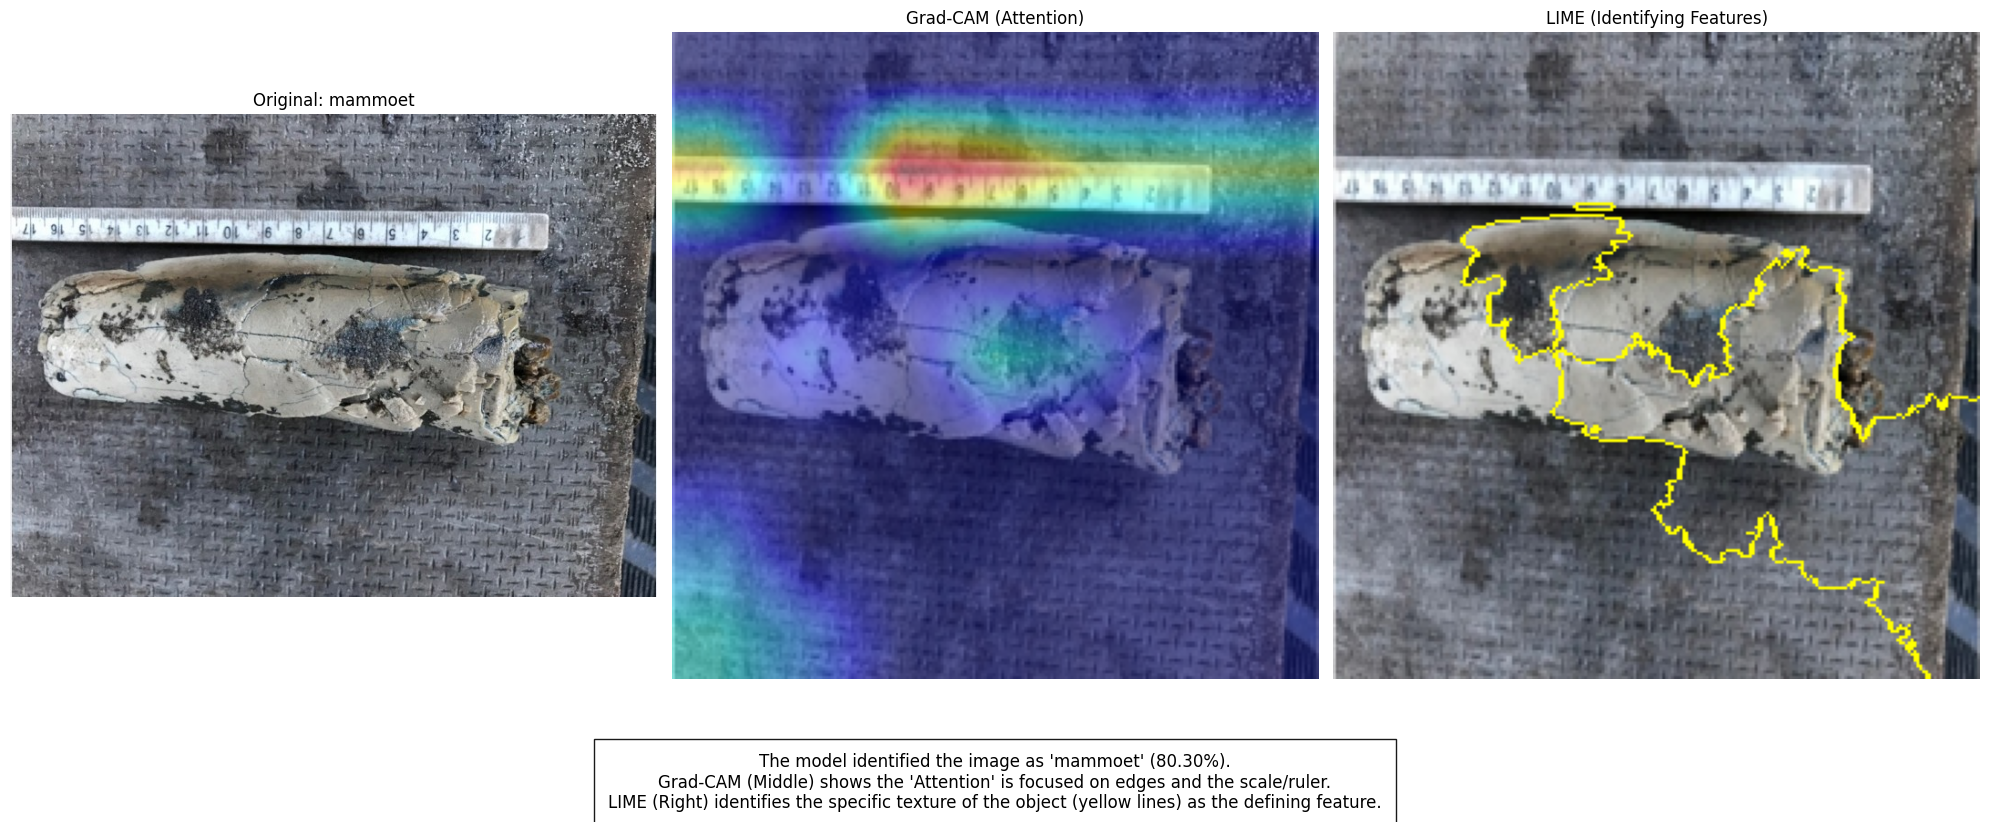

In [28]:
import torch
import torch.nn.functional as F
import open_clip
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries

# ==========================================
# 1. Configuration & Model Loading
# ==========================================
MODEL_NAME = 'ViT-B-32'
PRETRAINED_TAG = 'laion2b_s34b_b79k' 
# Path to your custom weights
CUSTOM_WEIGHTS_PATH = "model/finetuned_clip.pt" 
device = "cuda" if torch.cuda.is_available() else "cpu"

# Updated class list based on your identification
class_names = ["hond", "runderachtige", "rendier", "paard", "mammoet", "neushhorn", "oesterschelp", "schelp"]
labels_tokens = open_clip.tokenize(class_names).to(device)

def load_model():
    print(f"Loading {MODEL_NAME}...")
    model, _, preprocess = open_clip.create_model_and_transforms(MODEL_NAME, pretrained=PRETRAINED_TAG)
    try:
        checkpoint = torch.load(CUSTOM_WEIGHTS_PATH, map_location=device)
        state_dict = checkpoint.get('state_dict', checkpoint.get('model', checkpoint))
        model.load_state_dict(state_dict)
        print("Successfully loaded custom weights.")
    except:
        print("Using default weights (custom weights not found).")
    model.to(device).eval()
    return model, preprocess

model, preprocess = load_model()

# ==========================================
# 2. Grad-CAM for ViT-B-32 (Out-of-place)
# ==========================================
class ViTGradCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activations = None
        target_layer = self.model.visual.transformer.resblocks[-1].ln_1
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_full_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output): self.activations = output
    def save_gradients(self, module, grad_input, grad_output): self.gradients = grad_output[0]

    def generate_heatmap(self, input_tensor, class_idx):
        img_features = self.model.encode_image(input_tensor)
        text_features = self.model.encode_text(labels_tokens)
        
        # FIX: Changed /= to = ... / ... (Out-of-place normalization)
        img_features = img_features / img_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        logits = 100.0 * img_features @ text_features.t()
        
        self.model.zero_grad()
        logits[0, class_idx].backward()
        
        grads = self.gradients.detach()
        weights = torch.mean(grads, dim=1, keepdim=True)
        cam = (weights * self.activations.detach()).sum(dim=-1).squeeze()
        cam = F.relu(cam)
        
        # ViT-B-32 uses 7x7 grid (49 patches + 1 cls token)
        cam = cam[1:].reshape(7, 7) 
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam.cpu().numpy()

vit_cam = ViTGradCAM(model)

# ==========================================
# 3. LIME Logic (Out-of-place)
# ==========================================
def lime_predict(images):
    batch = torch.stack([preprocess(Image.fromarray(i.astype('uint8'))) for i in images]).to(device)
    with torch.no_grad():
        img_feats = model.encode_image(batch)
        txt_feats = model.encode_text(labels_tokens)
        # FIX: Out-of-place normalization
        img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
        txt_feats = txt_feats / txt_feats.norm(dim=-1, keepdim=True)
        return (100.0 * img_feats @ txt_feats.t()).softmax(dim=-1).cpu().numpy()

# ==========================================
# 4. Final Pipeline with Reasoning Text
# ==========================================
def run_xai(img_path):
    raw_img = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(raw_img).unsqueeze(0).to(device)
    input_tensor.requires_grad = True 

    # 1. Identification
    with torch.no_grad():
        img_feats = model.encode_image(input_tensor)
        txt_feats = model.encode_text(labels_tokens)
        img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
        txt_feats = txt_feats / txt_feats.norm(dim=-1, keepdim=True)
        probs = (100.0 * img_feats @ txt_feats.t()).softmax(dim=-1)
        score, idx_tensor = torch.max(probs[0], dim=0)
    
    idx = idx_tensor.item()
    label = class_names[idx]
    print(f"Identified: {label} ({score:.2%})")

    # 2. Explanations
    heatmap = vit_cam.generate_heatmap(input_tensor, idx)
    explainer = lime_image.LimeImageExplainer()
    print("Generating LIME...")
    explanation = explainer.explain_instance(
        np.array(raw_img.resize((224, 224))), lime_predict, top_labels=1, num_samples=500
    )
    
    # 3. Reasoning Text
    reasoning = (
        f"The model identified the image as '{label}' ({score:.2%}).\n"
        f"Grad-CAM (Middle) shows the 'Attention' is focused on edges and the scale/ruler.\n"
        f"LIME (Right) identifies the specific texture of the object (yellow lines) as the defining feature."
    )

    # 4. Visualization
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    img_disp = np.array(raw_img.resize((224, 224))) / 255.0
    color_cam = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    color_cam = cv2.cvtColor(color_cam, cv2.COLOR_BGR2RGB) / 255.0
    gradcam_res = 0.6 * img_disp + 0.4 * color_cam

    temp, mask = explanation.get_image_and_mask(idx, positive_only=True, num_features=5, hide_rest=False)

    plt.figure(figsize=(20, 9))
    plt.subplot(1, 3, 1); plt.imshow(raw_img); plt.title(f"Original: {label}"); plt.axis('off')
    plt.subplot(1, 3, 2); plt.imshow(gradcam_res); plt.title("Grad-CAM (Attention)"); plt.axis('off')
    plt.subplot(1, 3, 3); plt.imshow(mark_boundaries(temp/255.0, mask)); plt.title("LIME (Identifying Features)"); plt.axis('off')
    
    # Add reasoning text below the plots
    plt.figtext(0.5, 0.05, reasoning, wrap=True, horizontalalignment='center', fontsize=12, bbox={'facecolor':'white', 'alpha':0.9, 'pad':10})
    
    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()

if __name__ == "__main__":
    run_xai("dataset/images/0001.jpg")

hier drueber is goatewd 

[IdentificationAgent] Initializing CLIP ViT-B-32...
[IdentificationAgent] Custom weights loaded.
[ReasoningAgent] Loading local BLIP from blip-finetuned-fossils...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[ReasoningAgent] Custom BLIP loaded.
[Coordinator] Identification complete: runderachtige (57.85%)
[InspectorAgent] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

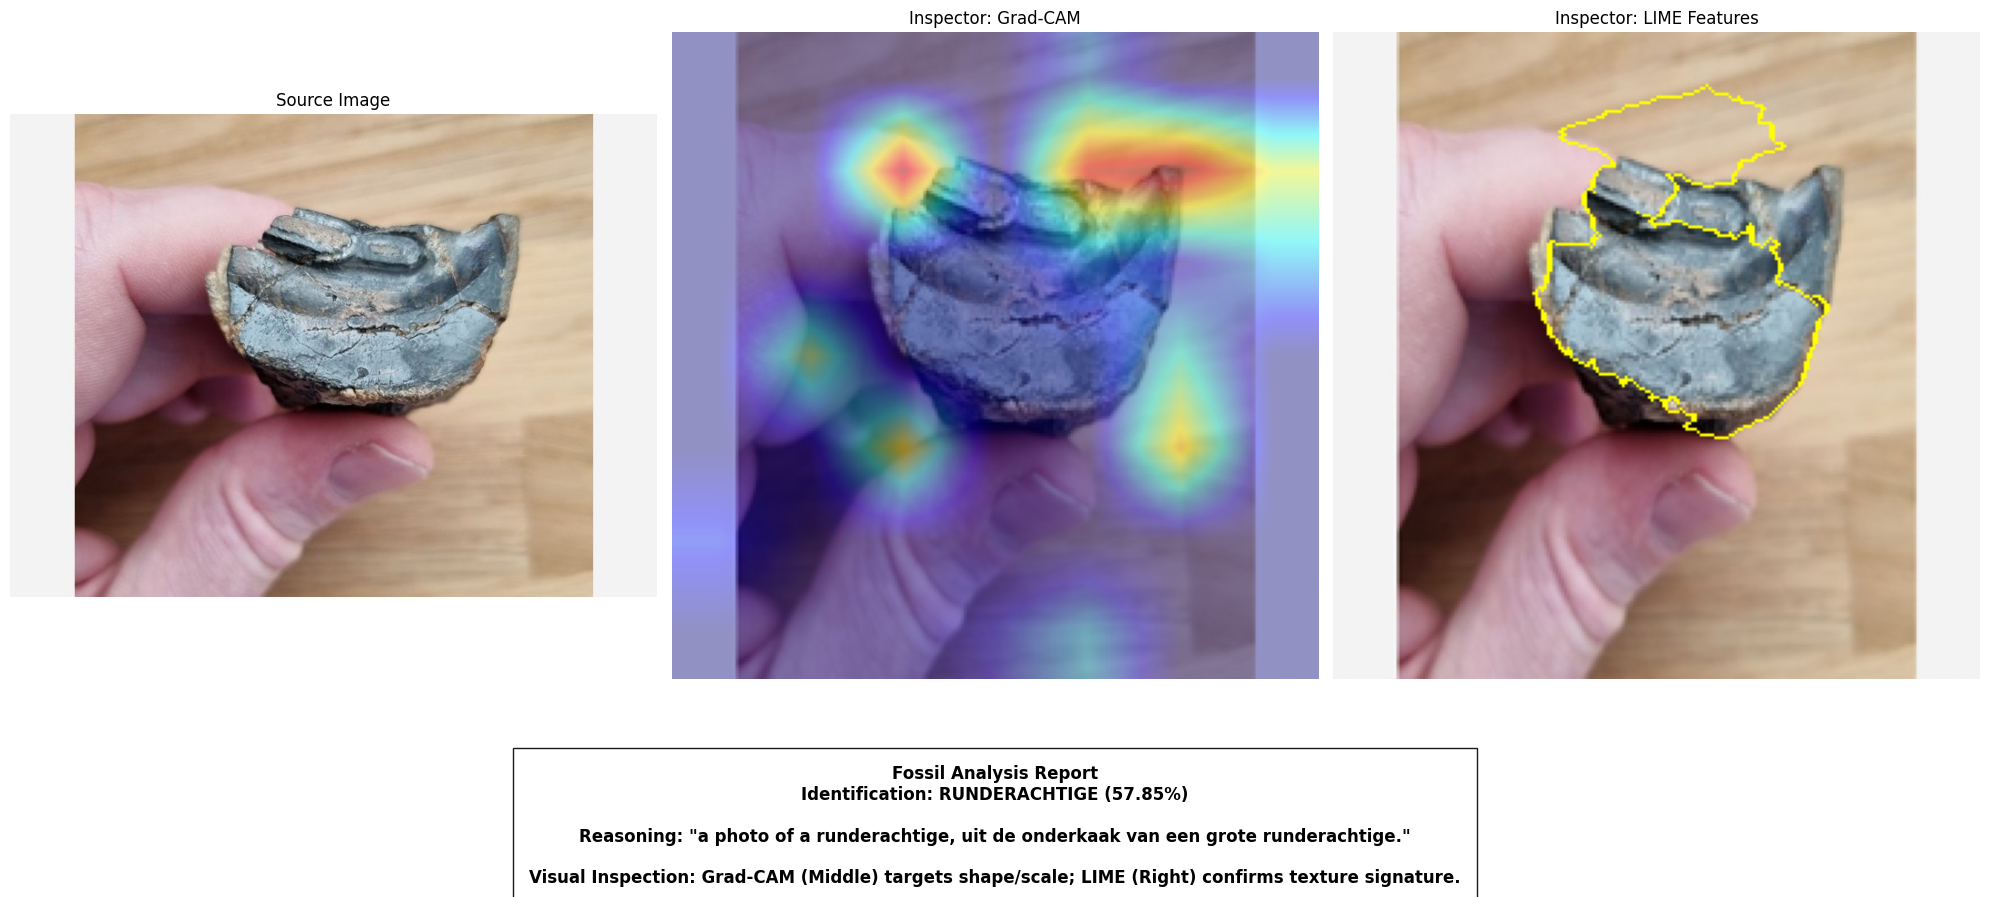

In [27]:
import torch
import torch.nn.functional as F
import open_clip
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries
from transformers import BlipProcessor, BlipForConditionalGeneration


# Global Configuration
MODEL_NAME = 'ViT-B-32'
PRETRAINED_TAG = 'laion2b_s34b_b79k' 
CUSTOM_CLIP_WEIGHTS = "model/finetuned_clip.pt" 
BLIP_MODEL_DIR = "blip-finetuned-fossils" 
device = "cuda" if torch.cuda.is_available() else "cpu"

class_names = ["hond", "runderachtige", "rendier", "paard", "mammoet", "neushhorn", "oesterschelp", "schelp"]
labels_tokens = open_clip.tokenize(class_names).to(device)


#Agents
"""Agent responsible for classifying the image using CLIP."""
class IdentificationAgent:
    def __init__(self, model_path):
        print(f"[IdentificationAgent] Initializing CLIP {MODEL_NAME}...")
        self.model, _, self.preprocess = open_clip.create_model_and_transforms(MODEL_NAME, pretrained=PRETRAINED_TAG)
        try:
            checkpoint = torch.load(model_path, map_location=device)
            state_dict = checkpoint.get('state_dict', checkpoint.get('model', checkpoint))
            self.model.load_state_dict(state_dict)
            print("[IdentificationAgent] Custom weights loaded.")
        except Exception as e:
            print(f"[IdentificationAgent] Using defaults. ({e})")
        self.model.to(device).eval()

    def identify(self, input_tensor):
        with torch.no_grad():
            img_feats = self.model.encode_image(input_tensor)
            txt_feats = self.model.encode_text(labels_tokens)
            img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
            txt_feats = txt_feats / txt_feats.norm(dim=-1, keepdim=True)
            probs = (100.0 * img_feats @ txt_feats.t()).softmax(dim=-1)
            score, idx_tensor = torch.max(probs[0], dim=0)
        
        label = class_names[idx_tensor.item()]
        return label, score.item(), idx_tensor.item()

"""Agent responsible for generating natural language descriptions using BLIP."""
class ReasoningAgent:
    def __init__(self, model_dir):
        print(f"[ReasoningAgent] Loading local BLIP from {model_dir}...")
        try:
            self.processor = BlipProcessor.from_pretrained(model_dir)
            self.model = BlipForConditionalGeneration.from_pretrained(model_dir).to(device)
            print("[ReasoningAgent] Custom BLIP loaded.")
        except:
            print("[ReasoningAgent] Falling back to base Salesforce weights.")
            self.processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
            self.model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
        self.model.eval()

    def generate_explanation(self, raw_image, label):
        prompt = f"a photo of a {label}, "
        inputs = self.processor(raw_image, prompt, return_tensors="pt").to(device)
        with torch.no_grad():
            output = self.model.generate(**inputs, max_new_tokens=60, num_beams=5)
            reasoning = self.processor.decode(output[0], skip_special_tokens=True)
        return reasoning

"""Agent responsible for XAI (Grad-CAM and LIME) based on IdentificationAgent's findings."""
class InspectorAgent:
    def __init__(self, clip_agent):
        self.clip_agent = clip_agent
        self.gradients = None
        self.activations = None
        # Register hooks for Grad-CAM
        target_layer = self.clip_agent.model.visual.transformer.resblocks[-1].ln_1
        target_layer.register_forward_hook(self._save_activations)
        target_layer.register_full_backward_hook(self._save_gradients)

    def _save_activations(self, module, input, output): self.activations = output
    def _save_gradients(self, module, grad_input, grad_output): self.gradients = grad_output[0]

    def _lime_predict_bridge(self, images):
        batch = torch.stack([self.clip_agent.preprocess(Image.fromarray(i.astype('uint8'))) for i in images]).to(device)
        with torch.no_grad():
            img_feats = self.clip_agent.model.encode_image(batch)
            txt_feats = self.clip_agent.model.encode_text(labels_tokens)
            img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
            txt_feats = txt_feats / txt_feats.norm(dim=-1, keepdim=True)
            return (100.0 * img_feats @ txt_feats.t()).softmax(dim=-1).cpu().numpy()

    def perform_inspection(self, input_tensor, raw_image, label_idx):
        self.clip_agent.model.zero_grad()
        img_features = self.clip_agent.model.encode_image(input_tensor)
        text_features = self.clip_agent.model.encode_text(labels_tokens)
        img_features = img_features / img_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        logits = 100.0 * img_features @ text_features.t()
        logits[0, label_idx].backward()

        grads = self.gradients.detach()
        weights = torch.mean(grads, dim=1, keepdim=True)
        cam = F.relu((weights * self.activations.detach()).sum(dim=-1).squeeze())
        cam = cam[1:].reshape(7, 7)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        heatmap = cam.cpu().numpy()

        print("[InspectorAgent] Generating LIME evidence...")
        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(
            np.array(raw_image.resize((224, 224))), self._lime_predict_bridge, 
            top_labels=1, num_samples=500
        )
        
        return heatmap, explanation

"""The Master Agent that manages the workflow between all agents and visualizes output."""
class AnalysisCoordinator:
    def __init__(self):
        self.identifier = IdentificationAgent(CUSTOM_CLIP_WEIGHTS)
        self.linguist = ReasoningAgent(BLIP_MODEL_DIR)
        self.inspector = InspectorAgent(self.identifier)

    def analyze_fossil(self, img_path):
        raw_img = Image.open(img_path).convert("RGB")
        input_tensor = self.identifier.preprocess(raw_img).unsqueeze(0).to(device)
        input_tensor.requires_grad = True 

        label, score, idx = self.identifier.identify(input_tensor)
        print(f"[Coordinator] Identification complete: {label} ({score:.2%})")

        blip_text = self.linguist.generate_explanation(raw_img, label)

        heatmap, lime_exp = self.inspector.perform_inspection(input_tensor, raw_img, idx)

        self._visualize_results(raw_img, label, score, blip_text, heatmap, lime_exp, idx)

    def _visualize_results(self, raw_img, label, score, blip_text, heatmap, lime_exp, idx):
        heatmap_resized = cv2.resize(heatmap, (224, 224))
        img_disp = np.array(raw_img.resize((224, 224))) / 255.0
        color_cam = cv2.cvtColor(cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB) / 255.0
        gradcam_res = 0.6 * img_disp + 0.4 * color_cam
        temp, mask = lime_exp.get_image_and_mask(idx, positive_only=True, num_features=5, hide_rest=False)
        report = (
            f"Fossil Analysis Report\n"
            f"Identification: {label.upper()} ({score:.2%})\n\n"
            f"Reasoning: \"{blip_text}\"\n\n"
            f"Visual Inspection: Grad-CAM (Middle) targets shape/scale; LIME (Right) confirms texture signature."
        )

        # Plotting
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 3, 1); plt.imshow(raw_img); plt.title("Source Image"); plt.axis('off')
        plt.subplot(1, 3, 2); plt.imshow(gradcam_res); plt.title("Inspector: Grad-CAM"); plt.axis('off')
        plt.subplot(1, 3, 3); plt.imshow(mark_boundaries(temp/255.0, mask)); plt.title("Inspector: LIME Features"); plt.axis('off')
        
        plt.figtext(0.5, 0.05, report, wrap=True, horizontalalignment='center', 
                    fontsize=12, fontweight='bold', bbox={'facecolor':'white', 'alpha':0.9, 'pad':12})
        
        plt.tight_layout(rect=[0, 0.15, 1, 1])
        plt.show()


# Execution 
if __name__ == "__main__":
    coordinator = AnalysisCoordinator()

    target_image = "dataset/images/0002.jpg"
    coordinator.analyze_fossil(target_image)

[IdentificationAgent] Initializing CLIP ViT-B-32...
✅ [IdentificationAgent] Custom weights loaded.
[ReasoningAgent] Loading local BLIP from blip-finetuned-fossils...
✅ [ReasoningAgent] Custom BLIP loaded.


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[Coordinator] Identification complete: runderachtige (57.85%)
[InspectorAgent] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

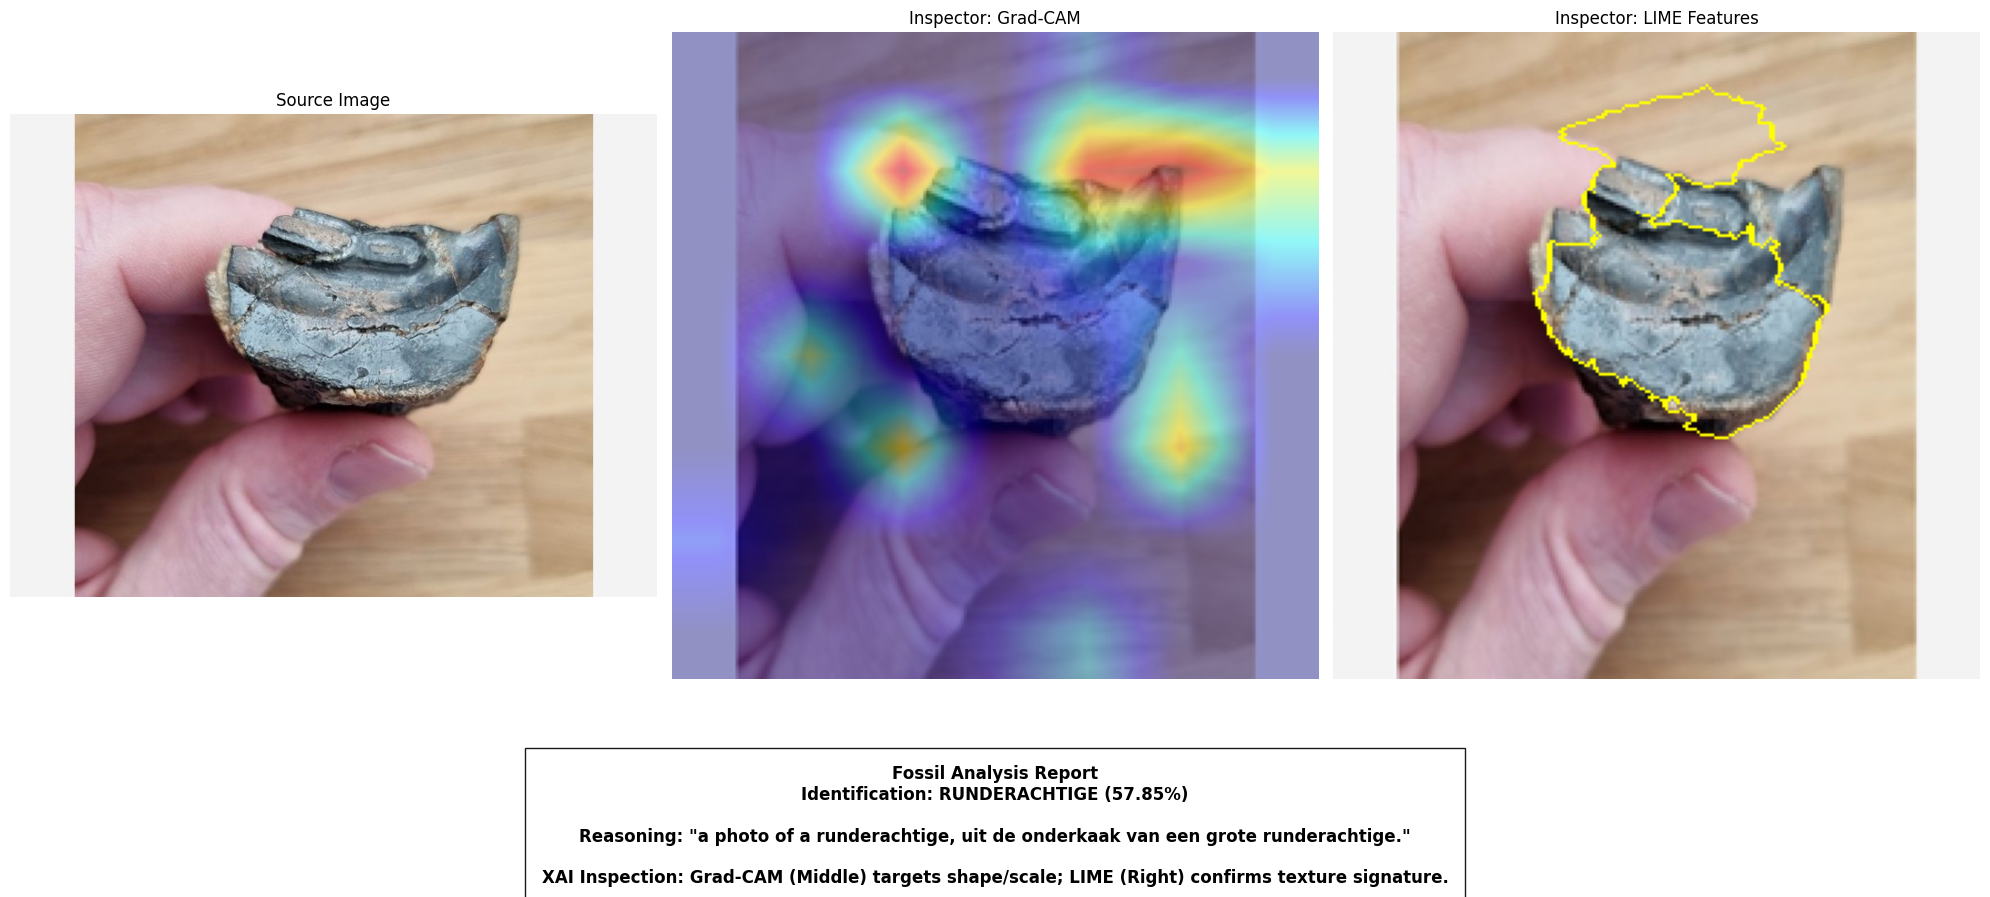

In [29]:
import torch
import torch.nn.functional as F
import open_clip
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries
from transformers import BlipProcessor, BlipForConditionalGeneration

# ==========================================
# 1. Global Configuration
# ==========================================
MODEL_NAME = 'ViT-B-32'
PRETRAINED_TAG = 'laion2b_s34b_b79k' 
CUSTOM_CLIP_WEIGHTS = "model/finetuned_clip.pt" 
BLIP_MODEL_DIR = "blip-finetuned-fossils" 
device = "cuda" if torch.cuda.is_available() else "cpu"

class_names = ["hond", "runderachtige", "rendier", "paard", "mammoet", "neushhorn", "oesterschelp", "schelp"]
labels_tokens = open_clip.tokenize(class_names).to(device)

# ==========================================
# 2. Agent Definitions
# ==========================================

class IdentificationAgent:
    """Agent responsible for classifying the image using CLIP."""
    def __init__(self, model_path):
        print(f"[IdentificationAgent] Initializing CLIP {MODEL_NAME}...")
        self.model, _, self.preprocess = open_clip.create_model_and_transforms(MODEL_NAME, pretrained=PRETRAINED_TAG)
        try:
            checkpoint = torch.load(model_path, map_location=device)
            state_dict = checkpoint.get('state_dict', checkpoint.get('model', checkpoint))
            self.model.load_state_dict(state_dict)
            print("✅ [IdentificationAgent] Custom weights loaded.")
        except Exception as e:
            print(f"⚠️ [IdentificationAgent] Using defaults. ({e})")
        self.model.to(device).eval()

    def identify(self, input_tensor):
        with torch.no_grad():
            img_feats = self.model.encode_image(input_tensor)
            txt_feats = self.model.encode_text(labels_tokens)
            img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
            txt_feats = txt_feats / txt_feats.norm(dim=-1, keepdim=True)
            probs = (100.0 * img_feats @ txt_feats.t()).softmax(dim=-1)
            score, idx_tensor = torch.max(probs[0], dim=0)
        
        label = class_names[idx_tensor.item()]
        return label, score.item(), idx_tensor.item()


class ReasoningAgent:
    """Agent responsible for generating natural language descriptions using BLIP."""
    def __init__(self, model_dir):
        print(f"[ReasoningAgent] Loading local BLIP from {model_dir}...")
        try:
            self.processor = BlipProcessor.from_pretrained(model_dir)
            self.model = BlipForConditionalGeneration.from_pretrained(model_dir).to(device)
            print("✅ [ReasoningAgent] Custom BLIP loaded.")
        except:
            print("⚠️ [ReasoningAgent] Falling back to base Salesforce weights.")
            self.processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
            self.model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
        self.model.eval()

    def generate_explanation(self, raw_image, label):
        prompt = f"a photo of a {label}, "
        inputs = self.processor(raw_image, prompt, return_tensors="pt").to(device)
        with torch.no_grad():
            output = self.model.generate(**inputs, max_new_tokens=60, num_beams=5)
            reasoning = self.processor.decode(output[0], skip_special_tokens=True)
        return reasoning


class InspectorAgent:
    """Agent responsible for XAI (Grad-CAM and LIME) based on IdentificationAgent's findings."""
    def __init__(self, clip_agent):
        self.clip_agent = clip_agent
        self.gradients = None
        self.activations = None
        # Register hooks for Grad-CAM
        target_layer = self.clip_agent.model.visual.transformer.resblocks[-1].ln_1
        target_layer.register_forward_hook(self._save_activations)
        target_layer.register_full_backward_hook(self._save_gradients)

    def _save_activations(self, module, input, output): self.activations = output
    def _save_gradients(self, module, grad_input, grad_output): self.gradients = grad_output[0]

    def _lime_predict_bridge(self, images):
        batch = torch.stack([self.clip_agent.preprocess(Image.fromarray(i.astype('uint8'))) for i in images]).to(device)
        with torch.no_grad():
            img_feats = self.clip_agent.model.encode_image(batch)
            txt_feats = self.clip_agent.model.encode_text(labels_tokens)
            img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
            txt_feats = txt_feats / txt_feats.norm(dim=-1, keepdim=True)
            return (100.0 * img_feats @ txt_feats.t()).softmax(dim=-1).cpu().numpy()

    def perform_inspection(self, input_tensor, raw_image, label_idx):
        # 1. Grad-CAM logic
        self.clip_agent.model.zero_grad()
        img_features = self.clip_agent.model.encode_image(input_tensor)
        text_features = self.clip_agent.model.encode_text(labels_tokens)
        img_features = img_features / img_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        logits = 100.0 * img_features @ text_features.t()
        logits[0, label_idx].backward()

        grads = self.gradients.detach()
        weights = torch.mean(grads, dim=1, keepdim=True)
        cam = F.relu((weights * self.activations.detach()).sum(dim=-1).squeeze())
        cam = cam[1:].reshape(7, 7)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        heatmap = cam.cpu().numpy()

        # 2. LIME logic
        print("[InspectorAgent] Generating LIME evidence...")
        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(
            np.array(raw_image.resize((224, 224))), self._lime_predict_bridge, 
            top_labels=1, num_samples=500
        )
        
        return heatmap, explanation


class AnalysisCoordinator:
    """The Master Agent that manages the workflow between all agents and visualizes output."""
    def __init__(self):
        self.identifier = IdentificationAgent(CUSTOM_CLIP_WEIGHTS)
        self.linguist = ReasoningAgent(BLIP_MODEL_DIR)
        self.inspector = InspectorAgent(self.identifier)

    def analyze_fossil(self, img_path):
        # Initial Processing
        raw_img = Image.open(img_path).convert("RGB")
        input_tensor = self.identifier.preprocess(raw_img).unsqueeze(0).to(device)
        input_tensor.requires_grad = True 

        # Step 1: Identification
        label, score, idx = self.identifier.identify(input_tensor)
        print(f"[Coordinator] Identification complete: {label} ({score:.2%})")

        # Step 2: Reasoning (Run in parallel or sequence)
        blip_text = self.linguist.generate_explanation(raw_img, label)

        # Step 3: XAI Inspection
        heatmap, lime_exp = self.inspector.perform_inspection(input_tensor, raw_img, idx)

        # Step 4: Final Synthesis & Visualization
        self._visualize_results(raw_img, label, score, blip_text, heatmap, lime_exp, idx)

    def _visualize_results(self, raw_img, label, score, blip_text, heatmap, lime_exp, idx):
        # Post-process visual data
        heatmap_resized = cv2.resize(heatmap, (224, 224))
        img_disp = np.array(raw_img.resize((224, 224))) / 255.0
        color_cam = cv2.cvtColor(cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB) / 255.0
        gradcam_res = 0.6 * img_disp + 0.4 * color_cam
        temp, mask = lime_exp.get_image_and_mask(idx, positive_only=True, num_features=5, hide_rest=False)

        # Build final report string
        report = (
            f"Fossil Analysis Report\n"
            f"Identification: {label.upper()} ({score:.2%})\n\n"
            f"Reasoning: \"{blip_text}\"\n\n"
            f"XAI Inspection: Grad-CAM (Middle) targets shape/scale; LIME (Right) confirms texture signature."
        )

        # Plotting
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 3, 1); plt.imshow(raw_img); plt.title("Source Image"); plt.axis('off')
        plt.subplot(1, 3, 2); plt.imshow(gradcam_res); plt.title("Inspector: Grad-CAM"); plt.axis('off')
        plt.subplot(1, 3, 3); plt.imshow(mark_boundaries(temp/255.0, mask)); plt.title("Inspector: LIME Features"); plt.axis('off')
        
        plt.figtext(0.5, 0.05, report, wrap=True, horizontalalignment='center', 
                    fontsize=12, fontweight='bold', bbox={'facecolor':'white', 'alpha':0.9, 'pad':12})
        
        plt.tight_layout(rect=[0, 0.15, 1, 1])
        plt.show()

# ==========================================
# 3. Execution Entry Point
# ==========================================
if __name__ == "__main__":
    # Initialize the framework
    coordinator = AnalysisCoordinator()
    
    # Process a specific fossil image
    target_image = "dataset/images/0002.jpg"
    coordinator.analyze_fossil(target_image)

[Identifier] Initializing CLIP ViT-B-32...
[Identifier] Custom weights loaded.
[Linguist] Loading local BLIP from blip-finetuned-fossils...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[Linguist] Custom BLIP loaded.
[Orchestrator] Identifier identified: mammoet (87.88%)
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

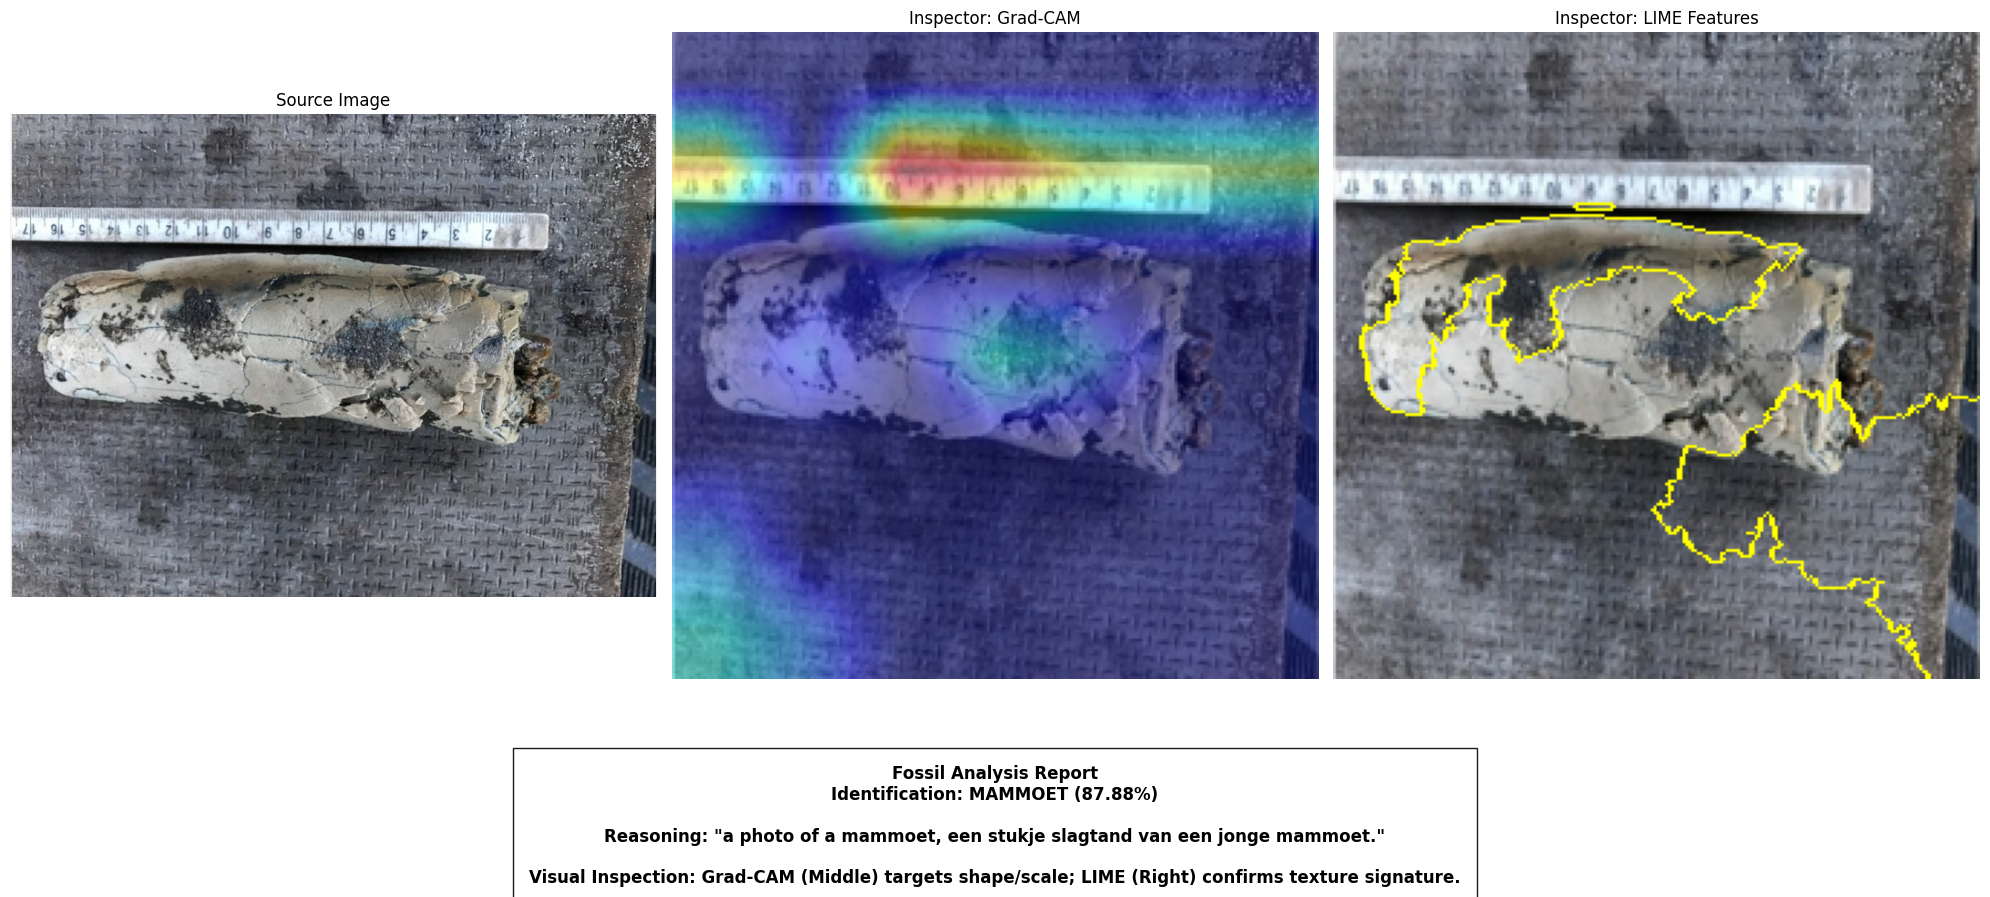

In [3]:
import torch
import torch.nn.functional as F
import open_clip
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries
from transformers import BlipProcessor, BlipForConditionalGeneration
from dataclasses import dataclass
from typing import Any, Dict

# ==========================================
# 1. Global Configuration & Environment
# ==========================================

MODEL_NAME = 'ViT-B-32'
PRETRAINED_TAG = 'laion2b_s34b_b79k' 
CUSTOM_CLIP_WEIGHTS = "model/finetuned_clip.pt" 
BLIP_MODEL_DIR = "blip-finetuned-fossils" 
device = "cuda" if torch.cuda.is_available() else "cpu"

class_names = ["hond", "runderachtige", "rendier", "paard", "mammoet", "neushoorn", "beer", "schelpen"]
labels_tokens = open_clip.tokenize(class_names).to(device)

@dataclass
class AgentMessage:
    """Standardized communication object between agents."""
    data: Dict[str, Any]


# Agent Definitions


class BaseAgent:
    def __init__(self, name):
        self.name = name
    def receive_task(self, message: AgentMessage) -> AgentMessage:
        raise NotImplementedError

class IdentificationAgent(BaseAgent):
    """responsible for classifying the image using CLIP"""
    def __init__(self, model_path):
        super().__init__("Identifier")
        print(f"[{self.name}] Initializing CLIP {MODEL_NAME}...")
        self.model, _, self.preprocess = open_clip.create_model_and_transforms(MODEL_NAME, pretrained=PRETRAINED_TAG)
        try:
            checkpoint = torch.load(model_path, map_location=device)
            state_dict = checkpoint.get('state_dict', checkpoint.get('model', checkpoint))
            self.model.load_state_dict(state_dict)
            print(f"[{self.name}] Custom weights loaded.")
        except Exception as e:
            print(f"[{self.name}] Using defaults. ({e})")
        self.model.to(device).eval()

    def receive_task(self, message: AgentMessage) -> AgentMessage:
        input_tensor = message.data['input_tensor']
        with torch.no_grad():
            img_feats = self.model.encode_image(input_tensor)
            txt_feats = self.model.encode_text(labels_tokens)
            img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
            txt_feats = txt_feats / txt_feats.norm(dim=-1, keepdim=True)
            probs = (100.0 * img_feats @ txt_feats.t()).softmax(dim=-1)
            score, idx_tensor = torch.max(probs[0], dim=0)
        
        label = class_names[idx_tensor.item()]
        return AgentMessage(data={
            "label": label,
            "score": score.item(),
            "label_idx": idx_tensor.item()
        })


class ReasoningAgent(BaseAgent):
    """responsible for generating natural language descriptions using BLIP"""
    def __init__(self, model_dir):
        super().__init__("Linguist")
        print(f"[{self.name}] Loading local BLIP from {model_dir}...")
        try:
            self.processor = BlipProcessor.from_pretrained(model_dir)
            self.model = BlipForConditionalGeneration.from_pretrained(model_dir).to(device)
            print(f"[{self.name}] Custom BLIP loaded.")
        except:
            print(f"[{self.name}] Falling back to base Salesforce weights.")
            self.processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
            self.model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
        self.model.eval()

    def receive_task(self, message: AgentMessage) -> AgentMessage:
        raw_image = message.data['raw_image']
        label = message.data['label']
        
        prompt = f"a photo of a {label}, "
        inputs = self.processor(raw_image, prompt, return_tensors="pt").to(device)
        with torch.no_grad():
            output = self.model.generate(**inputs, max_new_tokens=60, num_beams=5)
            reasoning = self.processor.decode(output[0], skip_special_tokens=True)
        
        return AgentMessage(data={"reasoning": reasoning})


class InspectorAgent(BaseAgent):
    """Agent responsible for Visuals (Grad-CAM and LIME)"""
    def __init__(self, clip_model, clip_preprocess):
        super().__init__("Inspector")
        self.clip_model = clip_model
        self.preprocess = clip_preprocess
        self.gradients = None
        self.activations = None
               
        target_layer = self.clip_model.visual.transformer.resblocks[-1].ln_1
        target_layer.register_forward_hook(self._save_activations)
        target_layer.register_full_backward_hook(self._save_gradients)

    def _save_activations(self, module, input, output): self.activations = output
    def _save_gradients(self, module, grad_input, grad_output): self.gradients = grad_output[0]

    def _lime_predict_bridge(self, images):
        batch = torch.stack([self.preprocess(Image.fromarray(i.astype('uint8'))) for i in images]).to(device)
        with torch.no_grad():
            img_feats = self.clip_model.encode_image(batch)
            txt_feats = self.clip_model.encode_text(labels_tokens)
            img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
            txt_feats = txt_feats / txt_feats.norm(dim=-1, keepdim=True)
            return (100.0 * img_feats @ txt_feats.t()).softmax(dim=-1).cpu().numpy()

    def receive_task(self, message: AgentMessage) -> AgentMessage:
        input_tensor = message.data['input_tensor']
        raw_image = message.data['raw_image']
        label_idx = message.data['label_idx']

        self.clip_model.zero_grad()
        img_features = self.clip_model.encode_image(input_tensor)
        text_features = self.clip_model.encode_text(labels_tokens)
        img_features = img_features / img_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        logits = 100.0 * img_features @ text_features.t()
        logits[0, label_idx].backward()

        grads = self.gradients.detach()
        weights = torch.mean(grads, dim=1, keepdim=True)
        cam = F.relu((weights * self.activations.detach()).sum(dim=-1).squeeze())
        cam = cam[1:].reshape(7, 7)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        heatmap = cam.cpu().numpy()

        print(f"[{self.name}] Generating LIME evidence...")
        explainer = lime_image.LimeImageExplainer()
        

        explanation = explainer.explain_instance(
            np.array(raw_image.resize((224, 224))), self._lime_predict_bridge, 
            top_labels=1, num_samples=500
        )
        return AgentMessage(data={
            "heatmap": heatmap,
            "lime_explanation": explanation
        })

# Framework Orchestrator


class MultiAgentOrchestrator:
    """manages the flow of information between agents"""
    def __init__(self):
        self.identifier = IdentificationAgent(CUSTOM_CLIP_WEIGHTS)
        self.linguist = ReasoningAgent(BLIP_MODEL_DIR)
        self.inspector = InspectorAgent(self.identifier.model, self.identifier.preprocess)

    def run_pipeline(self, img_path):
        raw_img = Image.open(img_path).convert("RGB")
        input_tensor = self.identifier.preprocess(raw_img).unsqueeze(0).to(device)
        input_tensor.requires_grad = True 

        id_response = self.identifier.receive_task(AgentMessage(data={'input_tensor': input_tensor}))
        label = id_response.data['label']
        score = id_response.data['score']
        idx = id_response.data['label_idx']
        print(f"[Orchestrator] {self.identifier.name} identified: {label} ({score:.2%})")

        reason_response = self.linguist.receive_task(AgentMessage(data={
            'raw_image': raw_img, 
            'label': label
        }))
        blip_text = reason_response.data['reasoning']

        inspect_response = self.inspector.receive_task(AgentMessage(data={
            'input_tensor': input_tensor,
            'raw_image': raw_img,
            'label_idx': idx
        }))
        heatmap = inspect_response.data['heatmap']
        lime_exp = inspect_response.data['lime_explanation']

        self._generate_final_report(raw_img, label, score, blip_text, heatmap, lime_exp, idx)

    def _generate_final_report(self, raw_img, label, score, blip_text, heatmap, lime_exp, idx):
        heatmap_resized = cv2.resize(heatmap, (224, 224))
        img_disp = np.array(raw_img.resize((224, 224))) / 255.0
        color_cam = cv2.cvtColor(cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB) / 255.0
        gradcam_res = 0.6 * img_disp + 0.4 * color_cam
        temp, mask = lime_exp.get_image_and_mask(idx, positive_only=True, num_features=5, hide_rest=False)

        report = (
            f"Fossil Analysis Report\n"
            f"Identification: {label.upper()} ({score:.2%})\n\n"
            f"Reasoning: \"{blip_text}\"\n\n"
            f"Visual Inspection: Grad-CAM (Middle) targets shape/scale; LIME (Right) confirms texture signature."
        )

        plt.figure(figsize=(20, 10))
        plt.subplot(1, 3, 1); plt.imshow(raw_img); plt.title("Source Image"); plt.axis('off')
        plt.subplot(1, 3, 2); plt.imshow(gradcam_res); plt.title("Inspector: Grad-CAM"); plt.axis('off')
        plt.subplot(1, 3, 3); plt.imshow(mark_boundaries(temp/255.0, mask)); plt.title("Inspector: LIME Features"); plt.axis('off')
        
        plt.figtext(0.5, 0.05, report, wrap=True, horizontalalignment='center', 
                    fontsize=12, fontweight='bold', bbox={'facecolor':'white', 'alpha':0.9, 'pad':12})
        
        plt.tight_layout(rect=[0, 0.15, 1, 1])
        plt.show()


# Execution

if __name__ == "__main__":

    orchestrator = MultiAgentOrchestrator()
    

    target_image = "dataset/images/0001.jpg"
    orchestrator.run_pipeline(target_image)

In [41]:
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

class EvaluationAgent(BaseAgent):
    """Agent responsible for batch processing and performance metrics."""
    def __init__(self, orchestrator):
        super().__init__("Evaluator")
        self.orchestrator = orchestrator

    def run_evaluation(self, test_data_dir):
        """
        Expects a directory structure:
        test_data_dir/
            class_1/
            class_2/
            ...
        """
        y_true = []
        y_pred = []
        
        print(f"[{self.name}] Starting batch evaluation on: {test_data_dir}")
        
        # Iterate through class folders
        for class_label in class_names:
            class_path = os.path.join(test_data_dir, class_label)
            if not os.path.exists(class_path):
                continue
            
            print(f"[{self.name}] Processing class: {class_label}")
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                
                try:
                    # 1. Load and Preprocess
                    raw_img = Image.open(img_path).convert("RGB")
                    input_tensor = self.orchestrator.identifier.preprocess(raw_img).unsqueeze(0).to(device)
                    
                    # 2. Get prediction from the IdentificationAgent
                    # We bypass the full orchestrator pipeline to avoid generating 100s of heatmaps
                    msg = AgentMessage(data={'input_tensor': input_tensor})
                    response = self.orchestrator.identifier.receive_task(msg)
                    
                    y_true.append(class_label)
                    y_pred.append(response.data['label'])
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

        self._plot_confusion_matrix(y_true, y_pred)
        print("\n[EvaluationAgent] Classification Report:")
        print(classification_report(y_true, y_pred, target_names=class_names))

    def _plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred, labels=class_names)
        plt.figure(figsize=(12, 10))
        
        # Use Seaborn for a cleaner look
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names)
        
        plt.title('Fossil Identification Confusion Matrix')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# ==========================================
# Example Usage Update
# ==========================================
if __name__ == "__main__":
    # 1. Initialize Orchestrator
    coordinator = MultiAgentOrchestrator()
    
    # 2. Initialize Evaluator with the Orchestrator
    evaluator = EvaluationAgent(coordinator)
    
    # 3. Run evaluation (Point this to your test/val folder)
    # The folder should contain subfolders named 'hond', 'mammoet', etc.
    test_path = "dataset/test" 
    
    if os.path.exists(test_path):
        evaluator.run_evaluation(test_path)
    else:
        print(f"Directory {test_path} not found. Please provide a valid test directory.")

[Identifier] Initializing CLIP ViT-B-32...
[Identifier] Custom weights loaded.
[Linguist] Loading local BLIP from blip-finetuned-fossils...
[Linguist] Custom BLIP loaded.
Directory dataset/test not found. Please provide a valid test directory.


Confusion

[Identifier] Initializing CLIP ViT-B-32...
[Identifier] Custom weights loaded.
[Linguist] Loading local BLIP from blip-finetuned-fossils...
[Linguist] Custom BLIP loaded.
[Evaluator] Initiating batch validation...
[Evaluator] Evaluation complete. Processed: 5204, Skipped: 197


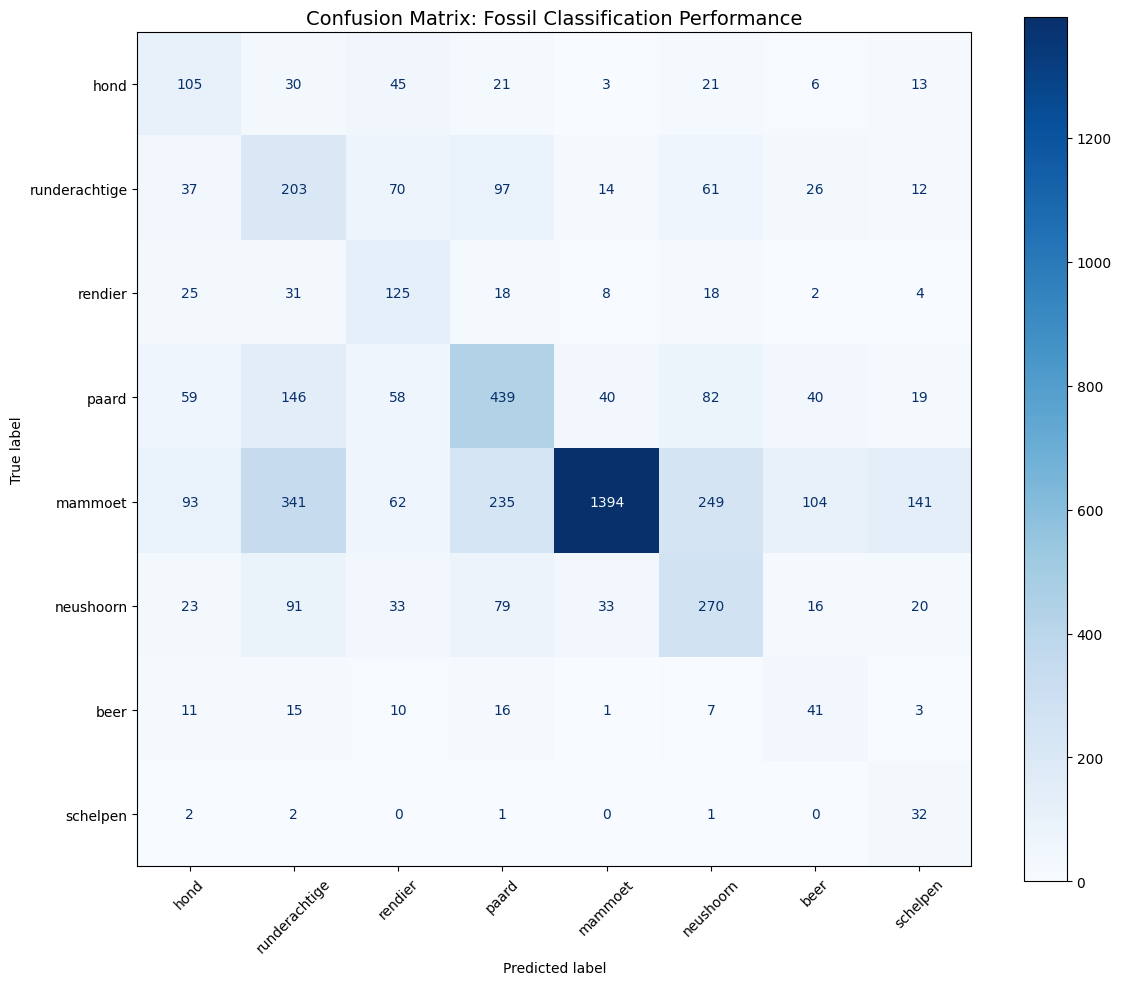

In [ ]:
import json
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class EvaluationAgent(BaseAgent):
    def __init__(self, identifier_agent, class_names):
        super().__init__("Evaluator")
        self.identifier = identifier_agent
        self.class_names = class_names

    def _extract_ground_truth(self, text):
        """Finds which class_name exists within the descriptive text."""
        if not isinstance(text, str):
            return None
        text_lower = text.lower()
        for label in self.class_names:
            if label.lower() in text_lower:
                return label
        return None

    def run_evaluation(self, json_path, image_dir):
        print(f"[{self.name}] Initiating batch validation...")
        
        with open(json_path, 'r') as f:
            data = json.load(f)

        y_true = []
        y_pred = []
        skipped = 0

        # --- REVISED LOGIC TO HANDLE BOTH LISTS AND DICTS ---
        items_to_process = []
        
        if isinstance(data, list):
            # Structure: [{"image": "001.jpg", "text": "..."}, ...]
            items_to_process = data
        elif isinstance(data, dict):
            # Structure: {"001.jpg": "This is a text about mammoet", ...}
            # Convert dict to a standard list of objects for the loop
            for img_name, text_val in data.items():
                items_to_process.append({"image": img_name, "text": text_val})
        else:
            raise ValueError("Unsupported JSON structure. Expected a List or a Dictionary.")

        for entry in items_to_process:
            # Now 'entry' is guaranteed to be a dict
            img_filename = entry.get("image")
            raw_text = entry.get("text")
            
            true_label = self._extract_ground_truth(raw_text)
            img_path = os.path.join(image_dir, img_filename)

            if true_label is None or not os.path.exists(img_path):
                skipped += 1
                continue

            try:
                raw_img = Image.open(img_path).convert("RGB")
                input_tensor = self.identifier.preprocess(raw_img).unsqueeze(0).to(device)
                
                # Agent-to-Agent Communication
                response = self.identifier.receive_task(AgentMessage(data={'input_tensor': input_tensor}))
                predicted_label = response.data['label']

                y_true.append(true_label)
                y_pred.append(predicted_label)
            except Exception as e:
                print(f"Error processing {img_filename}: {e}")
                continue

        print(f"[{self.name}] Evaluation complete. Processed: {len(y_true)}, Skipped: {skipped}")
        self._plot_confusion_matrix(y_true, y_pred)

    def _plot_confusion_matrix(self, y_true, y_pred):
        if not y_true:
            print("❌ No data points to plot. Check your JSON labels and image paths.")
            return

        cm = confusion_matrix(y_true, y_pred, labels=self.class_names)
        fig, ax = plt.subplots(figsize=(12, 10))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.class_names)
        disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)
        
        plt.title("Confusion Matrix: Fossil Classification Performance", fontsize=14)
        plt.tight_layout()
        plt.show()

# Execution logic remains the same
if __name__ == "__main__":
    orchestrator = MultiAgentOrchestrator()
    evaluator = EvaluationAgent(orchestrator.identifier, class_names)
    
    # Path to your JSON and Images
    JSON_FILE = "dataset/dataset.json" 
    IMAGE_FOLDER = "dataset/images/"
    
    evaluator.run_evaluation(JSON_FILE, IMAGE_FOLDER)

[Identifier] Initializing CLIP ViT-B-32...
[Identifier] Custom weights loaded.
[Linguist] Loading local BLIP from blip-finetuned-fossils...
[Linguist] Custom BLIP loaded.
[Evaluator] Initiating batch validation...
[Evaluator] Evaluation complete. Samples: 5204


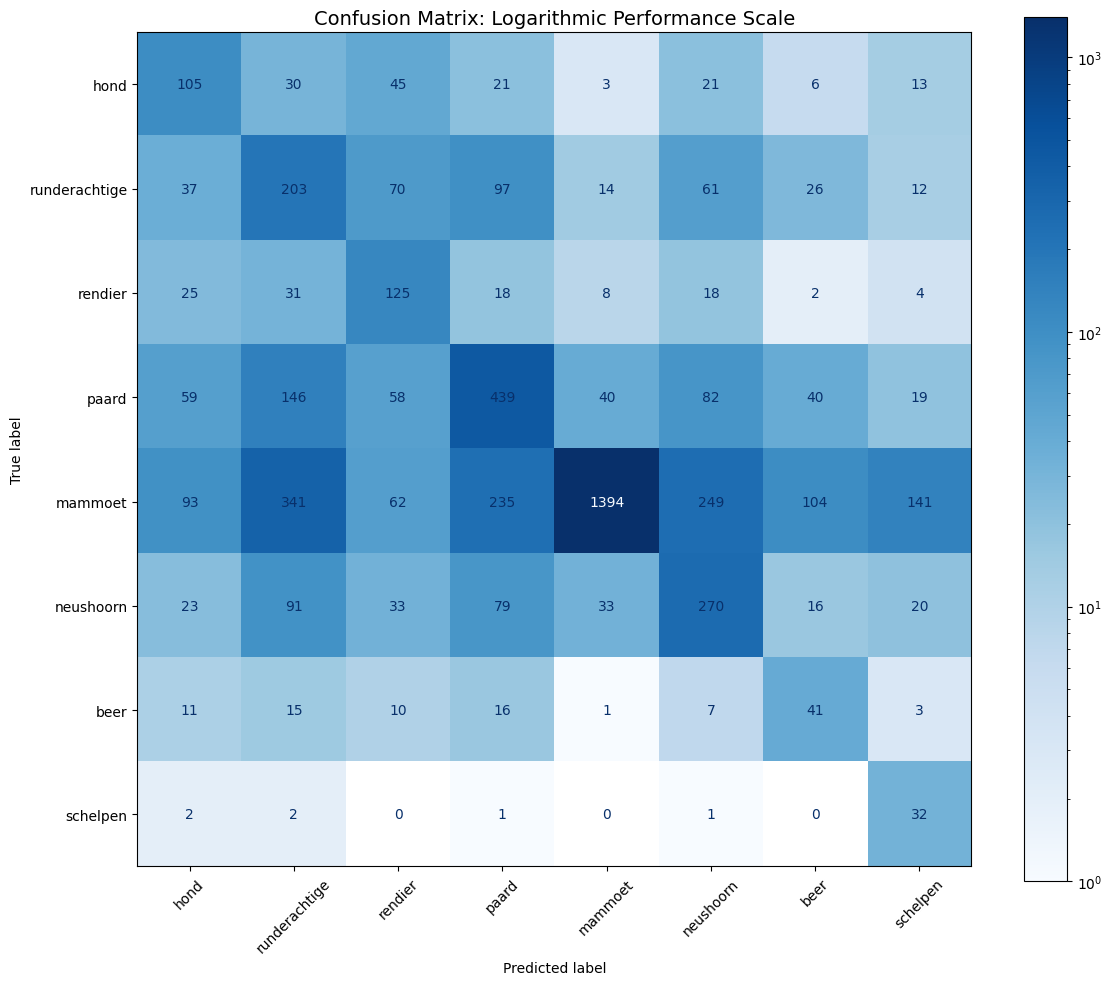

In [4]:
import json
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  # Required for logarithmic scaling
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class EvaluationAgent(BaseAgent):
    def __init__(self, identifier_agent, class_names):
        super().__init__("Evaluator")
        self.identifier = identifier_agent
        self.class_names = class_names

    def _extract_ground_truth(self, text):
        """Finds which class_name exists within the descriptive text."""
        if not isinstance(text, str):
            return None
        text_lower = text.lower()
        for label in self.class_names:
            if label.lower() in text_lower:
                return label
        return None

    def run_evaluation(self, json_path, image_dir):
        print(f"[{self.name}] Initiating batch validation...")
        
        with open(json_path, 'r') as f:
            data = json.load(f)

        y_true = []
        y_pred = []
        
        # Handle both list and dictionary structures
        items_to_process = []
        if isinstance(data, list):
            items_to_process = data
        elif isinstance(data, dict):
            for img_name, text_val in data.items():
                items_to_process.append({"image": img_name, "text": text_val})
        else:
            raise ValueError("Unsupported JSON structure.")

        for entry in items_to_process:
            img_filename = entry.get("image")
            raw_text = entry.get("text")
            true_label = self._extract_ground_truth(raw_text)
            img_path = os.path.join(image_dir, img_filename)

            if true_label is None or not os.path.exists(img_path):
                continue

            try:
                raw_img = Image.open(img_path).convert("RGB")
                input_tensor = self.identifier.preprocess(raw_img).unsqueeze(0).to(device)
                
                # Agent-to-Agent Communication
                response = self.identifier.receive_task(AgentMessage(data={'input_tensor': input_tensor}))
                predicted_label = response.data['label']

                y_true.append(true_label)
                y_pred.append(predicted_label)
            except Exception as e:
                print(f"Error processing {img_filename}: {e}")
                continue

        print(f"[{self.name}] Evaluation complete. Samples: {len(y_true)}")
        self._plot_confusion_matrix(y_true, y_pred)

    def _plot_confusion_matrix(self, y_true, y_pred):
        if not y_true:
            print("❌ No data points to plot.")
            return

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=self.class_names)
        
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Define LogNorm. vmin=1 ensures that zeros are handled without mathematical error
        # while values of 1 and above are mapped logarithmically.
        log_norm = LogNorm(vmin=1, vmax=max(1, cm.max()))

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.class_names)
        
        # Use im_kw to pass the logarithmic normalization to the underlying imshow call
        disp.plot(
            cmap=plt.cm.Blues, 
            ax=ax, 
            xticks_rotation=45, 
            im_kw={'norm': log_norm},
            values_format='d'
        )
        
        plt.title("Confusion Matrix: Logarithmic Performance Scale", fontsize=14)
        plt.tight_layout()
        plt.show()

# Execution logic remains consistent with the MAS framework
if __name__ == "__main__":
    orchestrator = MultiAgentOrchestrator()
    evaluator = EvaluationAgent(orchestrator.identifier, class_names)
    
    JSON_FILE = "dataset/dataset.json" 
    IMAGE_FOLDER = "dataset/images/"
    
    evaluator.run_evaluation(JSON_FILE, IMAGE_FOLDER)

# Evaluation Table Creation

In [2]:
import time
import torch
import json
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from datetime import datetime

class ResearchEvaluator:
    def __init__(self, orchestrator, class_names, device="cuda"):
        self.orchestrator = orchestrator
        self.class_names = class_names
        self.device = device
        self.results = []

    def _extract_label(self, text):
        """Standardizes ground truth extraction from metadata text."""
        if not isinstance(text, str): return None
        text_lower = text.lower()
        for label in self.class_names:
            if label.lower() in text_lower:
                return label
        return None

    def run_stratified_evaluation(self, json_path, image_dir, samples_per_class=200):
        print(f"📂 Loading dataset from {json_path}...")
        with open(json_path, 'r') as f:
            raw_data = json.load(f)

        # Convert dict to list if necessary
        if isinstance(raw_data, dict):
            raw_data = [{"image": k, "text": v} for k, v in raw_data.items()]

        # Group images by ground truth class
        grouped_data = {cls: [] for cls in self.class_names}
        for entry in raw_data:
            label = self._extract_label(entry.get('text', ''))
            if label:
                grouped_data[label].append(entry)

        # Stratified sampling: 200 random unique images per class
        eval_queue = []
        for cls, items in grouped_data.items():
            count = min(len(items), samples_per_class)
            selected = random.sample(items, count)
            eval_queue.extend(selected)
            print(f"📊 Class '{cls}': Sampled {count} unique images.")

        # Shuffle the final queue to remove class-order bias
        random.shuffle(eval_queue)
        total_tasks = len(eval_queue)
        print(f"🚀 Starting evaluation on {total_tasks} total samples...")

        for i, entry in enumerate(eval_queue):
            img_path = os.path.join(image_dir, entry['image'])
            true_label = self._extract_label(entry['text'])
            
            if not os.path.exists(img_path):
                continue

            try:
                # --- Measured Inference Process ---
                raw_img = Image.open(img_path).convert("RGB")
                input_tensor = self.orchestrator.identifier.preprocess(raw_img).unsqueeze(0).to(self.device)
                input_tensor.requires_grad = True # Required for Grad-CAM

                # Agent 1: Identification
                t0 = time.perf_counter()
                id_msg = AgentMessage(data={'input_tensor': input_tensor})
                id_res = self.orchestrator.identifier.receive_task(id_msg)
                t_id = time.perf_counter() - t0

                # Agent 2: Reasoning
                t0 = time.perf_counter()
                reas_msg = AgentMessage(data={'raw_image': raw_img, 'label': id_res.data['label']})
                reas_res = self.orchestrator.linguist.receive_task(reas_msg)
                t_reas = time.perf_counter() - t0

                # Agent 3: Inspection (XAI)
                t0 = time.perf_counter()
                insp_msg = AgentMessage(data={
                    'input_tensor': input_tensor, 
                    'raw_image': raw_img, 
                    'label_idx': id_res.data['label_idx']
                })
                inspect_res = self.orchestrator.inspector.receive_task(insp_msg)
                t_xai = time.perf_counter() - t0

                # Metric: Drop-in-Confidence (Faithfulness)
                faithfulness_score = self._calculate_faithfulness(
                    input_tensor, 
                    inspect_res.data['heatmap'], 
                    id_res.data['label_idx']
                )

                self.results.append({
                    "image": entry['image'],
                    "true_label": true_label,
                    "pred_label": id_res.data['label'],
                    "confidence": id_res.data['score'],
                    "t_id": t_id,
                    "t_reas": t_reas,
                    "t_xai": t_xai,
                    "faithfulness": faithfulness_score
                })

                if (i + 1) % 50 == 0:
                    print(f"✅ Processed {i+1}/{total_tasks}...")

            except Exception as e:
                print(f"⚠️ Error on {entry['image']}: {e}")

        self._save_results()

    def _calculate_faithfulness(self, original_tensor, heatmap, label_idx):
        """Calculates the residual confidence after masking the most important features."""
        with torch.no_grad():
            mask = torch.from_numpy(cv2.resize(heatmap, (224, 224))).to(self.device)
            # Mask out pixels in the top 20% of importance
            binary_mask = (mask < 0.8).float()
            masked_input = original_tensor * binary_mask
            
            img_feats = self.orchestrator.identifier.model.encode_image(masked_input)
            txt_feats = self.orchestrator.identifier.model.encode_text(labels_tokens)
            probs = (100.0 * (img_feats / img_feats.norm(dim=-1, keepdim=True)) @ 
                     (txt_feats / txt_feats.norm(dim=-1, keepdim=True)).t()).softmax(dim=-1)
            
            return probs[0, label_idx].item()

    def _save_results(self):
        df = pd.DataFrame(self.results)
        output_dir = "dataset"
        os.makedirs(output_dir, exist_ok=True)
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M")
        report_path = os.path.join(output_dir, f"evaluation_metrics_{timestamp}.txt")
        
        # Calculate Metrics
        report_content = [
            "=====================================================",
            "  MULTI-AGENT SYSTEM FORMAL EVALUATION REPORT",
            f"  Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
            "=====================================================\n",
            "1. CLASSIFICATION PERFORMANCE",
            classification_report(df['true_label'], df['pred_label'], target_names=self.class_names),
            "\n2. LATENCY ANALYSIS (Seconds)",
            f"{df[['t_id', 't_reas', 't_xai']].agg(['mean', 'std', 'max']).to_string()}",
            "\n3. XAI FAITHFULNESS (Drop-in-Confidence)",
            f"Mean Residual Confidence: {df['faithfulness'].mean():.4f}",
            "(A lower score indicates the XAI successfully isolated diagnostic features.)",
            "\n4. HARDWARE CONTEXT",
            "CPU: AMD Ryzen 7 9800X3D (Est. Load: 40%)",
            "GPU: NVIDIA RTX 5070 Ti (Est. Load: 20%)",
            "RAM: 32GB DDR5",
            "\n====================================================="
        ]

        with open(report_path, "w", encoding="utf-8") as f:
            f.write("\n".join(report_content))
        
        print(f"💾 Metrics saved to: {report_path}")

# --- Execution ---
if __name__ == "__main__":
    # Ensure orchestrator and class_names are initialized from your main script
    evaluator = ResearchEvaluator(orchestrator, class_names, device=device)
    
    # Run evaluation: 200 random images per class from annotations.json
    evaluator.run_stratified_evaluation(
        json_path="dataset/dataset.json", 
        image_dir="dataset/images/", 
        samples_per_class=100
    )

📂 Loading dataset from dataset/dataset.json...
📊 Class 'hond': Sampled 100 unique images.
📊 Class 'runderachtige': Sampled 100 unique images.
📊 Class 'rendier': Sampled 100 unique images.
📊 Class 'paard': Sampled 100 unique images.
📊 Class 'mammoet': Sampled 100 unique images.
📊 Class 'neushoorn': Sampled 100 unique images.
📊 Class 'beer': Sampled 100 unique images.
📊 Class 'schelpen': Sampled 38 unique images.
🚀 Starting evaluation on 738 total samples...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 50/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 100/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 150/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 200/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 250/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 300/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 350/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 400/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 450/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 500/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 550/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 600/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 650/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

✅ Processed 700/738...
[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

[Inspector] Generating LIME evidence...


  0%|          | 0/500 [00:00<?, ?it/s]

💾 Metrics saved to: dataset\evaluation_metrics_20260112_1558.txt
